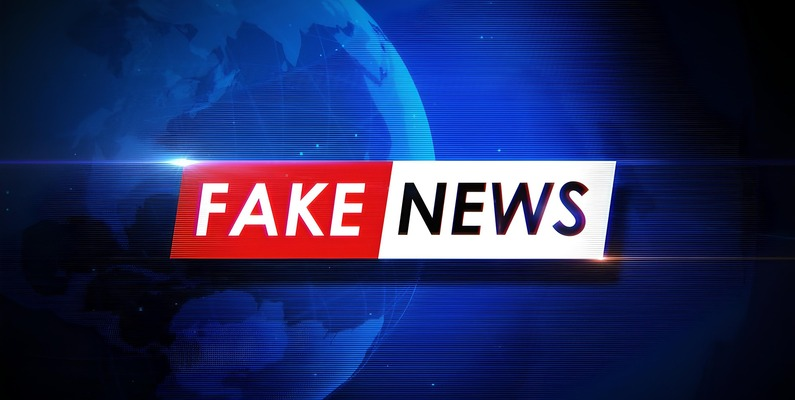

**Import the necessary libraries**

In [145]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
#News Importation
true_news = pd.read_csv("/content/True.csv")
fake_news = pd.read_csv("/content/Fake.csv")

In [31]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [32]:
#Checking for missing datapoints
true_news.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [33]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [34]:
#Checking for missing datapoints
fake_news.isnull().sum()

,0
title,0
text,0
subject,0
date,0


**DATA PREPROCESSING**

In [35]:
fake_news.duplicated().sum(), true_news.duplicated().sum()

(np.int64(3), np.int64(206))

In [36]:
true_news.drop_duplicates(inplace=True)
fake_news.drop_duplicates(inplace=True)

In [37]:
true_news["target"] = 1
fake_news["target"] = 0

In [38]:
true_news.drop(["subject", "date", "text"], axis=1, inplace=True)
fake_news.drop(["subject", "date", "text"], axis=1, inplace=True)

In [39]:
total_news = 2000
fake_news = fake_news[:total_news]
true_news = true_news[:total_news]
len(fake_news), len(true_news)

(2000, 2000)

In [40]:
news = pd.concat([true_news, fake_news], ignore_index=True)
news = news.sample(frac=1, random_state=42).reset_index(drop=True)
news.head()

,title,target
0,Haitians in U.S. malign Trump decision to send...,1
1,Republicans Were Just Told To Stop Talking Ab...,0
2,Republican Senator Paul says he plans to vote ...,1
3,DNC Chair Not Holding Back On GOP: ‘They Don’...,0
4,WATCH: Rand Paul Accidentally Admits We Need ...,0


In [41]:
news.isnull().sum()

,0
title,0
target,0


In [42]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   4000 non-null   object
 1   target  4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


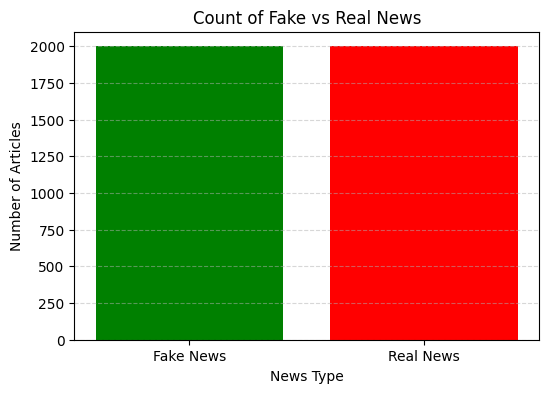

In [43]:
# Count fake and real news
news_counts = news["target"].value_counts()
# Plot
plt.figure(figsize=(6, 4))
plt.bar(news_counts.index.map({0: "Real News", 1: "Fake News"}), news_counts.values, color=['green', 'red'])
plt.title("Count of Fake vs Real News")
plt.xlabel("News Type")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [44]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(news)):
  review = re.sub('[^a-zA-Z]', ' ', news['title'][i])
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  review = ' '.join(review)
  corpus.append(review)

In [45]:
corpus

['haitian u malign trump decis send back home',
 'republican told stop talk healthcar repeal polit suicid detail',
 'republican senat paul say plan vote senat tax bill',
 'dnc chair hold back gop give sh peopl video',
 'watch rand paul accident admit need nation healthcar',
 'trump twitter dec tax bill',
 'republican senat cruz push percent corpor tax rate',
 'women accus trump sexual misconduct seek congression probe',
 'republican propos delay paus obamacar tax',
 'india order investig paradis paper leak',
 'trump fcc decim internet freedom video',
 'trump slap lawsuit refus releas white hous visitor log',
 'settlement propos north carolina transgend bathroom lawsuit',
 'facebook googl twitter ask testifi russian meddl',
 'syrian air base trump spent million attack yesterday alreadi bomb raid',
 'bust trump pick top usda scientist scientist',
 'justic depart creat post overse asset forfeitur program',
 'nearli half american oppos republican tax bill reuter ipso poll',
 'u lawmak seek

**One-hot representation**

In [119]:
voc_size = 7000
onehot_repr = [one_hot(words, voc_size)for words in corpus]
onehot_repr

[[1623, 121, 1736, 4567, 5318, 1479, 1916, 3532],
 [6239, 6403, 856, 1532, 5201, 3324, 3563, 4619, 1071],
 [6239, 3875, 2550, 788, 3048, 1870, 3875, 2443, 4433],
 [1232, 3103, 2925, 1916, 5382, 419, 1208, 5060, 1634],
 [3495, 5555, 2550, 758, 5055, 3451, 2840, 5201],
 [4567, 1951, 5461, 2443, 4433],
 [6239, 3875, 5746, 4922, 2878, 6784, 2443, 2001],
 [4388, 1129, 4567, 5844, 3158, 1572, 1467, 4411],
 [6239, 994, 3425, 773, 731, 2443],
 [4542, 79, 3839, 5580, 2883, 2653],
 [4567, 6863, 5036, 3556, 5945, 1634],
 [4567, 2344, 5288, 3512, 3840, 2392, 6474, 6779, 2370],
 [4264, 994, 1520, 1902, 83, 3676, 5288],
 [4279, 3237, 1951, 5077, 5164, 1176, 3244],
 [5328, 5403, 6460, 4567, 135, 6399, 6400, 2537, 5094, 2460, 2102],
 [3589, 4567, 6163, 6222, 5739, 5204, 5204],
 [1984, 5386, 894, 1808, 3707, 2981, 1858, 6426],
 [2957, 6037, 820, 756, 6239, 2443, 4433, 802, 4773, 1667],
 [121, 3852, 1572, 4787, 4567, 506, 5734, 709, 3469, 4411],
 [1123, 4567, 1091, 1107, 5833, 4560, 3221, 5287, 3006],
 

**Embedding Representation**

In [120]:
set_length = 30
embedded_docs = pad_sequences(onehot_repr, padding = "pre", maxlen = set_length)
print(embedded_docs)

[[   0    0    0 ... 1479 1916 3532]
 [   0    0    0 ... 3563 4619 1071]
 [   0    0    0 ... 3875 2443 4433]
 ...
 [   0    0    0 ...  524 2189 4931]
 [   0    0    0 ...  696  310 4168]
 [   0    0    0 ... 6711 6176 6130]]


In [121]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1623,  121, 1736, 4567, 5318, 1479, 1916, 3532], dtype=int32)

In [122]:
# X and y variable
y = np.array(news["target"])
X = np.array(embedded_docs)

In [123]:
X.shape, y.shape

((4000, 30), (4000,))

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [126]:
vocab_size = 7000  # vocab size
embedding_dim = 100  # Embedding output size
maxlen = 30  # Sequence length
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, maxlen))
model.summary()  # Now should show proper param counts

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)             │ (None, 30, 100)             │         700,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 817,377 (3.12 MB)

 Trainable params: 817,377 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [127]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6598 - loss: 0.6169 - val_accuracy: 0.8988 - val_loss: 0.2292
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9433 - loss: 0.1466 - val_accuracy: 0.9350 - val_loss: 0.1901
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9824 - loss: 0.0563 - val_accuracy: 0.9187 - val_loss: 0.2241
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9911 - loss: 0.0313 - val_accuracy: 0.9200 - val_loss: 0.2574
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9972 - loss: 0.0170 - val_accuracy: 0.9225 - val_loss: 0.2939
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0097 - val_accuracy: 0.9162 - val_loss: 0.3369
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0070 - val_accuracy: 0.9087 - val_loss: 0.3737
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 0.9162 - val_

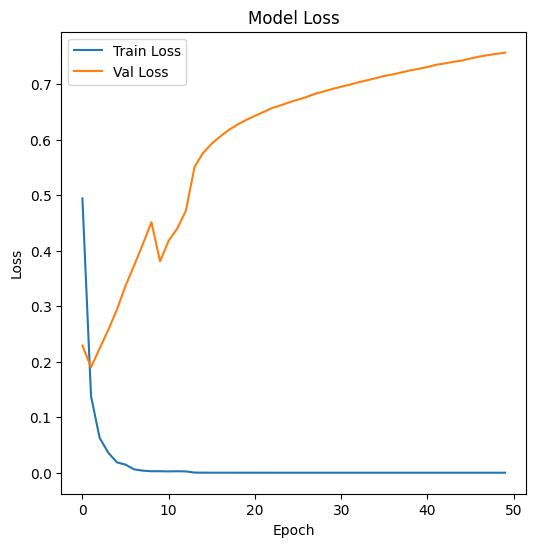

In [128]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [129]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [134]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 91.500%


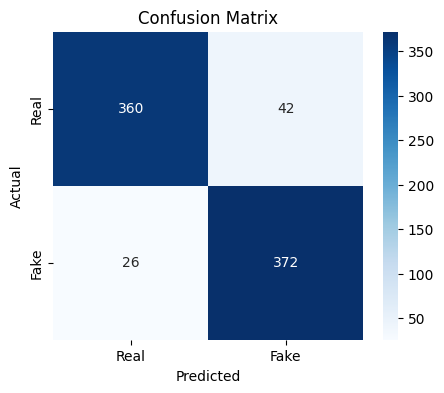

In [135]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       402
           1       0.90      0.93      0.92       398

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.91       800
weighted avg       0.92      0.92      0.91       800



**BI-DIRECTIONAL LSTM**

In [138]:
vocab_size = 7000     # vocabulary size
embedding_dim = 100   # embedding vector dimensions
maxlen = 30           # max sequence length
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))  # Bi-directional LSTM
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, maxlen))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)             │ (None, 30, 100)             │         700,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 934,753 (3.57 MB)

 Trainable params: 934,753 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6634 - loss: 0.6478 - val_accuracy: 0.8925 - val_loss: 0.3358
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9426 - loss: 0.1883 - val_accuracy: 0.9187 - val_loss: 0.2031
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9681 - loss: 0.0907 - val_accuracy: 0.9275 - val_loss: 0.2036
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9930 - loss: 0.0357 - val_accuracy: 0.9212 - val_loss: 0.2527
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9962 - loss: 0.0153 - val_accuracy: 0.9225 - val_loss: 0.2914
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9967 - loss: 0.0145 - val_accuracy: 0.9187 - val_loss: 0.3434
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0045 - val_accuracy: 0.9175 - val_loss: 0.3375
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9920 - loss: 0.0295 - val_accuracy: 0.9175 - val_l

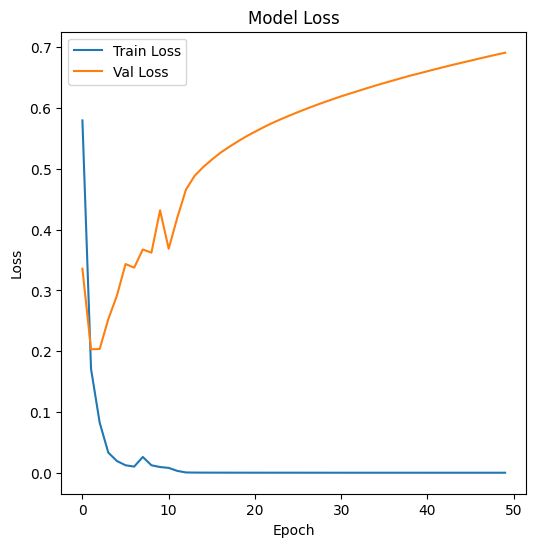

In [140]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [141]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [142]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 91.625%


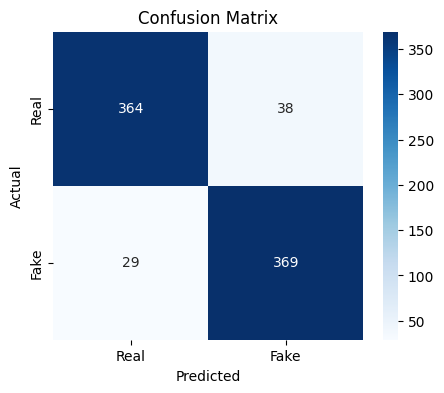

In [143]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       402
           1       0.91      0.93      0.92       398

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



**GRU-LSTM model**

In [192]:
vocab_size = 7000
embedding_dim = 100
maxlen = 30
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(GRU(units=128, return_sequences=True))  # Pass sequence output to next LSTM
# Second layer: LSTM
model.add(LSTM(units=64, return_sequences=False))
# Dropout for regularization
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and summary
model.build((None, maxlen))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)             │ (None, 30, 100)             │         700,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 30, 128)             │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 837,793 (3.20 MB)

 Trainable params: 837,793 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6641 - loss: 0.6017 - val_accuracy: 0.8975 - val_loss: 0.2567
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9419 - loss: 0.1589 - val_accuracy: 0.9175 - val_loss: 0.2224
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9830 - loss: 0.0558 - val_accuracy: 0.9062 - val_loss: 0.2713
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9954 - loss: 0.0172 - val_accuracy: 0.9050 - val_loss: 0.3544
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9991 - loss: 0.0110 - val_accuracy: 0.9062 - val_loss: 0.4045
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.8938 - val_loss: 0.4431
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9965 - loss: 0.0090 - val_accuracy: 0.9000 - val_loss: 0.4486
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9013 - val

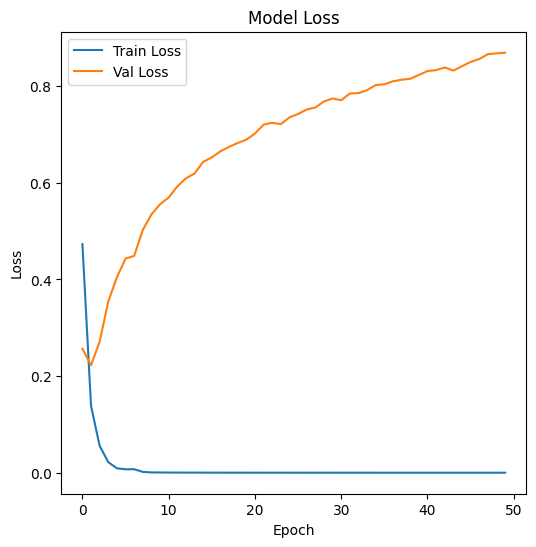

In [194]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [195]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [196]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 89.750%


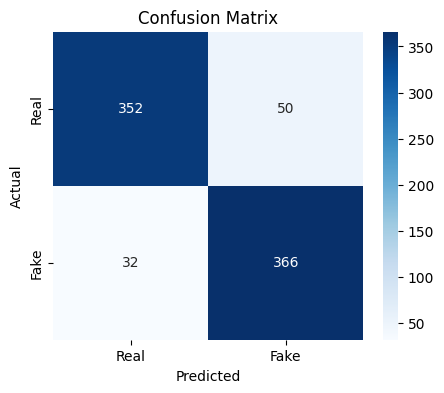

In [197]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [198]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       402
           1       0.88      0.92      0.90       398

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



**USING A LEMMATIZER**

In [152]:
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For lemmatizer’s vocabulary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [153]:
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(0, len(news)):
    review = re.sub('[^a-zA-Z]', ' ', news['title'][i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [154]:
corpus

['haitian u malign trump decision send back home',
 'republican told stop talking healthcare repeal political suicide detail',
 'republican senator paul say plan vote senate tax bill',
 'dnc chair holding back gop give sh people video',
 'watch rand paul accidentally admits need nationalized healthcare',
 'trump twitter dec tax bill',
 'republican senator cruz push percent corporate tax rate',
 'woman accusing trump sexual misconduct seek congressional probe',
 'republican propose delay pause obamacare tax',
 'india order investigation paradise paper leak',
 'trump fcc decimate internet freedom video',
 'trump slapped lawsuit refusing release white house visitor log',
 'settlement proposed north carolina transgender bathroom lawsuit',
 'facebook google twitter asked testify russian meddling',
 'syrian air base trump spent million attacking yesterday already bombing raid',
 'busted trump pick top usda scientist scientist',
 'justice department create post overseeing asset forfeiture pro

In [155]:
#One-hot encoding
voc_size = 7000
onehot_repr = [one_hot(words, voc_size)for words in corpus]
onehot_repr

[[1623, 121, 1736, 4567, 3066, 1479, 1916, 3532],
 [6239, 6403, 856, 1423, 6469, 3324, 5107, 1198, 1071],
 [6239, 5358, 2550, 788, 3048, 1870, 497, 2443, 4433],
 [1232, 3103, 1867, 1916, 5382, 419, 1208, 2425, 1634],
 [3495, 5555, 2550, 6589, 2162, 3451, 4571, 6469],
 [4567, 1951, 5461, 2443, 4433],
 [6239, 5358, 5746, 4922, 2878, 814, 2443, 2001],
 [1516, 1257, 4567, 5844, 3158, 1572, 4495, 4411],
 [6239, 5028, 3425, 681, 247, 2443],
 [4542, 79, 2716, 5958, 2883, 2653],
 [4567, 6863, 533, 3556, 5945, 1634],
 [4567, 1209, 5288, 435, 5556, 2392, 4251, 6779, 2370],
 [4264, 1172, 1520, 1902, 3100, 3676, 5288],
 [4279, 4965, 1951, 4112, 4589, 1176, 3028],
 [5328, 5403, 6460, 4567, 135, 6399, 2600, 2537, 4582, 6984, 2102],
 [6099, 4567, 6163, 6222, 5739, 5204, 5204],
 [3297, 4998, 5712, 1808, 2113, 2981, 2358, 6426],
 [6474, 6037, 820, 2864, 6239, 2443, 4433, 3524, 2545, 1667],
 [121, 5758, 1572, 5978, 4567, 506, 5734, 709, 3469, 4411],
 [3871, 4567, 1091, 1107, 5833, 4560, 3221, 5306, 1935

In [156]:
set_length = 30
embedded_docs = pad_sequences(onehot_repr, padding = "pre", maxlen = set_length)
print(embedded_docs)

[[   0    0    0 ... 1479 1916 3532]
 [   0    0    0 ... 5107 1198 1071]
 [   0    0    0 ...  497 2443 4433]
 ...
 [   0    0    0 ...  524 2189 6732]
 [   0    0    0 ...  696  310 1499]
 [   0    0    0 ... 4780 4589 6130]]


In [158]:
# X and y variable
y = np.array(news["target"])
X = np.array(embedded_docs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [185]:
vocab_size = 7000  # vocab size
embedding_dim = 100  # Embedding output size
maxlen = 30  # Sequence length
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, maxlen))
model.summary()  # Now should show proper param counts

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)             │ (None, 30, 100)             │         700,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 817,377 (3.12 MB)

 Trainable params: 817,377 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6730 - loss: 0.6038 - val_accuracy: 0.9062 - val_loss: 0.2394
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9335 - loss: 0.1707 - val_accuracy: 0.9237 - val_loss: 0.2050
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9771 - loss: 0.0703 - val_accuracy: 0.9187 - val_loss: 0.2389
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9951 - loss: 0.0210 - val_accuracy: 0.9100 - val_loss: 0.2780
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9978 - loss: 0.0114 - val_accuracy: 0.9112 - val_loss: 0.3754
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0124 - val_accuracy: 0.9038 - val_loss: 0.4576
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0033 - val_accuracy: 0.9062 - val_loss: 0.4263
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0021 - val_accuracy: 0.8988 - val_

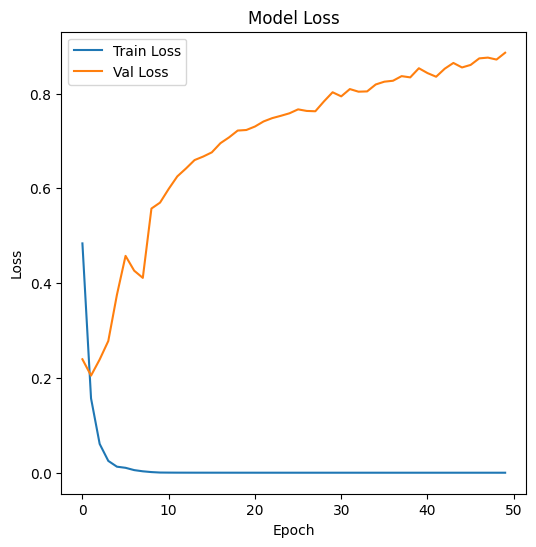

In [187]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [188]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [189]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 89.000%


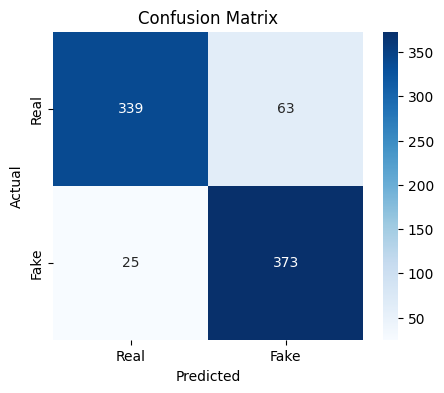

In [190]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [191]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       402
           1       0.86      0.94      0.89       398

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



**BI-DIRECTIONAL LSTM**

In [178]:
vocab_size = 7000     # vocabulary size
embedding_dim = 100   # embedding vector dimensions
maxlen = 30           # max sequence length
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))  # Bi-directional LSTM
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, maxlen))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)             │ (None, 30, 100)             │         700,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 934,753 (3.57 MB)

 Trainable params: 934,753 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [179]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6834 - loss: 0.6320 - val_accuracy: 0.8612 - val_loss: 0.3237
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9231 - loss: 0.2016 - val_accuracy: 0.9025 - val_loss: 0.2182
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9677 - loss: 0.0886 - val_accuracy: 0.9150 - val_loss: 0.2157
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9860 - loss: 0.0459 - val_accuracy: 0.9200 - val_loss: 0.2572
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9961 - loss: 0.0146 - val_accuracy: 0.9062 - val_loss: 0.3040
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.8988 - val_loss: 0.2843
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9954 - loss: 0.0213 - val_accuracy: 0.9062 - val_loss: 0.3064
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.8950 - val_

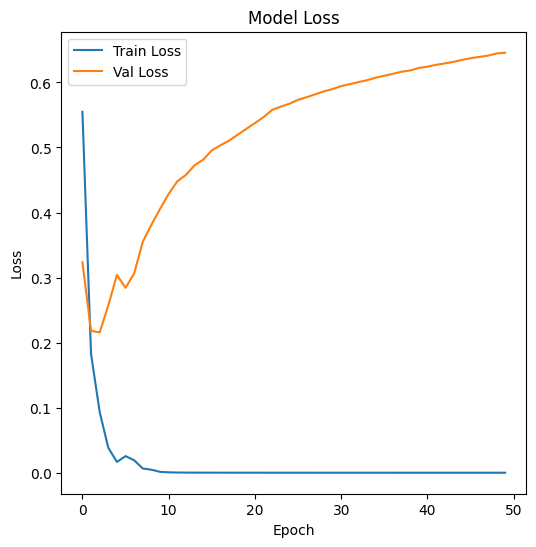

In [180]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [181]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [182]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 90.375%


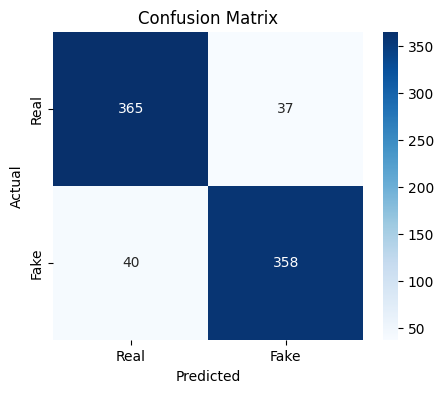

In [183]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       402
           1       0.91      0.90      0.90       398

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



**GRU-LSTM**

In [171]:
vocab_size = 7000
embedding_dim = 100
maxlen = 30
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(GRU(units=128, return_sequences=True))  # Pass sequence output to next LSTM
# Second layer: LSTM
model.add(LSTM(units=64, return_sequences=False))
# Dropout for regularization
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and summary
model.build((None, maxlen))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)             │ (None, 30, 100)             │         700,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 30, 128)             │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 837,793 (3.20 MB)

 Trainable params: 837,793 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=64, validation_data = (X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6109 - loss: 0.6277 - val_accuracy: 0.8975 - val_loss: 0.2472
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9466 - loss: 0.1626 - val_accuracy: 0.9212 - val_loss: 0.2151
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9892 - loss: 0.0531 - val_accuracy: 0.9175 - val_loss: 0.2503
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0189 - val_accuracy: 0.9175 - val_loss: 0.2898
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9982 - loss: 0.0118 - val_accuracy: 0.8975 - val_loss: 0.4056
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9967 - loss: 0.0093 - val_accuracy: 0.8975 - val_loss: 0.3807
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8888 - val_loss: 0.4645
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.8913 - val_loss

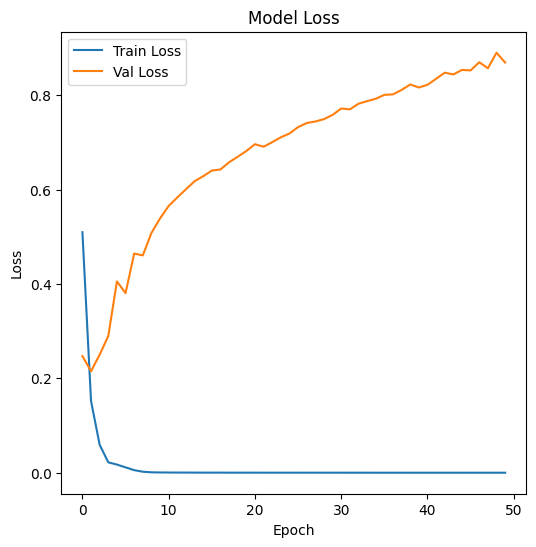

In [173]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [174]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [175]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.3f}%")

Accuracy: 89.375%


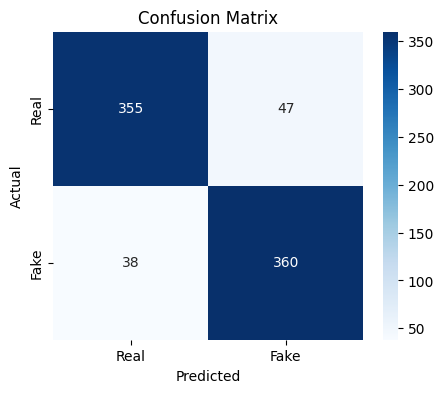

In [176]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [177]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       402
           1       0.88      0.90      0.89       398

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800

